In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import models, datasets
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

class notMNIST(Dataset):
    def __init__(self, data, labels):
        self.images = data
        self.labels = labels

        self.transformation = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        img_tensor = self.transformation(img)
        y_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor.view(1, 28, 28), y_tensor

data = loadmat('data/notMNIST_small.mat')
print(data.keys())

images = data['images']
labels = data['labels']

images = [images[:, :, i] for i in range(0, images.shape[2])]
images = np.asarray(images)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, shuffle=True)

train_dataset = notMNIST(x_train, y_train)
test_dataset = notMNIST(x_test, y_test)

dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])


In [24]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # Input layer: 28*28 neurons (for each pixel in the image)
        # First hidden layer: 512 neurons
        self.fc1 = nn.Linear(28*28, 512)
        
        # Second hidden layer: 256 neurons
        self.fc2 = nn.Linear(512, 256)
        
        # Third hidden layer: 128 neurons
        self.fc3 = nn.Linear(256, 128)
        
        # Output layer: 10 neurons (one for each class A-J)
        self.fc4 = nn.Linear(128, 10)
        
        # Activation function: ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 32 output channels
        # Kernel size: 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 window
        
        # Second convolutional layer: 32 input channels, 64 output channels
        # Kernel size: 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Fully connected layer: 64*7*7 input neurons (from the last convolutional layer)
        # 128 output neurons
        self.fc1 = nn.Linear(64*7*7, 128)
        
        # Output layer: 128 input neurons, 10 output neurons (one for each class A-J)
        self.fc2 = nn.Linear(128, 10)
        
        # Activation function: ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [26]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        # Call the parent __init__ function
        super(BasicCNN, self).__init__()

        # First convolutional layer:
        # 1 input channel (because the image is grayscale),
        # 32 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        
        # Second convolutional layer:
        # 32 input channels (from the previous layer),
        # 64 output channels, 3x3 square convolution kernel
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        # Dropout layer to reduce overfitting; drops 25% of nodes
        self.dropout1 = nn.Dropout(0.25)
        
        # Another dropout layer, but drops 50% of nodes
        self.dropout2 = nn.Dropout(0.5)
        
        # First fully connected (dense) layer: 
        # 9216 input features (from the previous layer after flattening),
        # 128 output features
        self.fc1 = nn.Linear(9216, 128)
        
        # Second fully connected layer that reduces to 10 outputs (for the 10 classes A-J)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass input through the first convolutional layer, then apply ReLU activation function
        x = self.conv1(x)
        x = F.relu(x)

        # Pass through the second convolutional layer, then apply ReLU activation
        x = self.conv2(x)
        x = F.relu(x)

        # Apply max pooling with 2x2 window
        x = F.max_pool2d(x, 2)

        # Apply first dropout layer
        x = self.dropout1(x)

        # Flatten the tensor
        x = torch.flatten(x, 1)

        # Pass through the first fully connected layer, then apply ReLU activation
        x = self.fc1(x)
        x = F.relu(x)

        # Apply second dropout layer
        x = self.dropout2(x)

        # Pass through the second fully connected layer
        x = self.fc2(x)

        # Apply softmax to get probabilities; return result
        return F.log_softmax(x, dim=1)


In [27]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        
        # Initial convolutional layers are the same as BasicCNN
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Additional deeper convolutional layers
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Adjusted input features for the fully connected layer based on the deeper architecture
        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    # The forward method structure is similar to BasicCNN but has added layers
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [28]:
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        
        # Only one dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # Adjusted input features for the single fully connected layer
        self.fc1 = nn.Linear(32 * 26 * 26, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


In [29]:
# initialize the models
mlp_model = MLP()
cnn_model = DeepCNN()


In [30]:
# define the loss functions and optimizers
criterion = nn.CrossEntropyLoss()

mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

In [31]:
# Training
def train_model(model, optimizer, criterion, dataloader, epochs=10):
    """
    Train a given model using the specified optimizer and criterion.

    Args:
    - model: PyTorch model to be trained
    - optimizer: Optimizer for updating model parameters
    - criterion: Loss function
    - dataloader: DataLoader for the training data
    - epochs: Number of epochs (default=10)

    Returns:
    - list of losses per epoch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()  # Set the model to training mode
    loss_list = []  # To store the loss per epoch

    # Loop over epochs
    for epoch in trange(epochs, desc="Epochs"):
        # ... [rest of the code remains unchanged]
        epoch_loss = 0  # Initialize epoch loss

        for inputs, labels in tqdm(dataloader, desc="Batches", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_list.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    model.eval()
    return loss_list

In [32]:
def evaluate_model(model, dataloader):
    """
    Evaluate the given model using the specified dataloader.

    Args:
    - model: Trained PyTorch model
    - dataloader: DataLoader for the evaluation data

    Returns:
    - Accuracy of the model on the evaluation data
    """
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluation", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)  # Move inputs and labels to the device and ensure float32 type
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy



In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model.to(device)

# Training the MLP model
mlp_losses = train_model(mlp_model, mlp_optimizer, criterion, DataLoader(train_dataset, batch_size=64, shuffle=True), epochs=10)

# Evaluating the MLP model
mlp_accuracy = evaluate_model(mlp_model, DataLoader(test_dataset, batch_size=64))
print(f"MLP Model Accuracy: {mlp_accuracy:.2f}%")

# Assuming cnn_model is defined and moved to the correct device as well:
cnn_model.to(device)

# Training the CNN model
cnn_losses = train_model(cnn_model, cnn_optimizer, criterion, DataLoader(train_dataset, batch_size=64, shuffle=True), epochs=10)

# Evaluating the CNN model
cnn_accuracy = evaluate_model(cnn_model, DataLoader(test_dataset, batch_size=64))
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}%")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 1.0460


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 0.3611


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 0.3122


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 0.2534


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 0.2409


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 0.2047


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 0.2053


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 8/10 - Loss: 0.1866


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 9/10 - Loss: 0.1680


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 10/10 - Loss: 0.1768


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

MLP Model Accuracy: 90.67%


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 35.0665


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 4.4431


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 2.2179


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 1.3549


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 1.0371


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 0.8023


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 0.7875


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 8/10 - Loss: 0.6479


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 9/10 - Loss: 0.5471


Batches:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 10/10 - Loss: 0.4821


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

CNN Model Accuracy: 91.23%


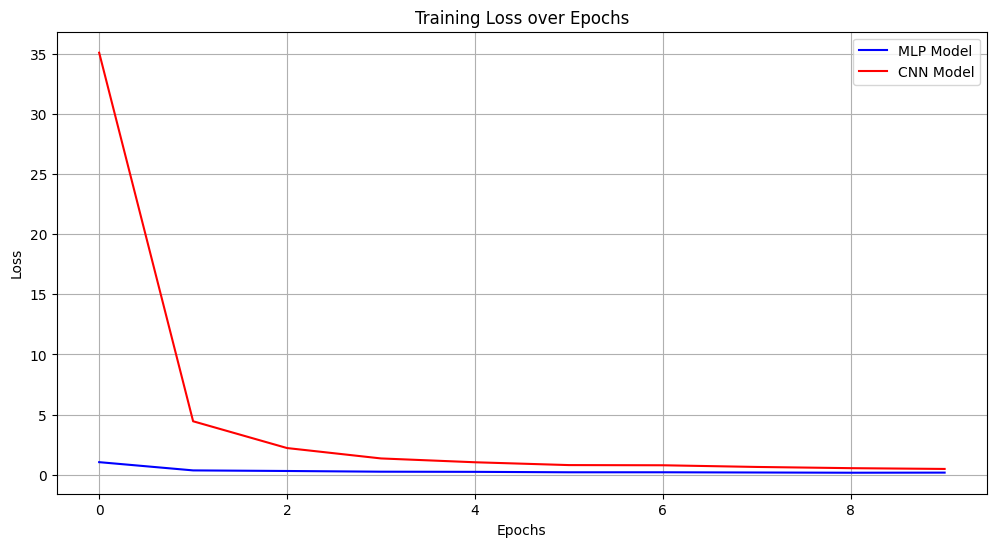

In [34]:
import matplotlib.pyplot as plt

def plot_losses(mlp_losses, cnn_losses):
    # Initialize a new figure for plotting with a specified size.
    plt.figure(figsize=(12, 6))
    
    # Plot the MLP model's losses in blue.
    plt.plot(mlp_losses, label="MLP Model", color='blue')
    
    # Plot the CNN model's losses in red.
    plt.plot(cnn_losses, label="CNN Model", color='red')
    
    # Title of the plot.
    plt.title("Training Loss over Epochs")
    
    # Labels for the x and y axes.
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    # Display the legend to differentiate between MLP and CNN.
    plt.legend()
    
    # Display a grid for better readability.
    plt.grid(True)
    
    # Show the plot.
    plt.show()

plot_losses(mlp_losses, cnn_losses)



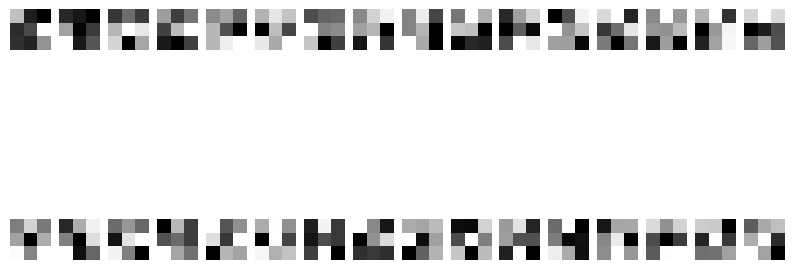

In [35]:
def plot_filters(layer):
    # Extract filter weights from the layer and convert to numpy for visualization.
    filters = layer.weight.data.cpu().numpy()
    
    # Initialize a figure for displaying multiple images.
    fig = plt.figure(figsize=(10, 5))
    
    # Loop through each filter in the layer.
    for i in range(filters.shape[0]):
        ax = fig.add_subplot(2, filters.shape[0]//2, i+1) # arranging subplots in 2 rows.
        
        # Display the filter as an image.
        ax.imshow(filters[i][0], cmap='gray')
        
        # Don't show axis for clarity.
        ax.axis('off')
    
    # Show all the filter images.
    plt.show()

# Assuming your CNN model's first layer is named 'conv1'.
plot_filters(cnn_model.conv1)


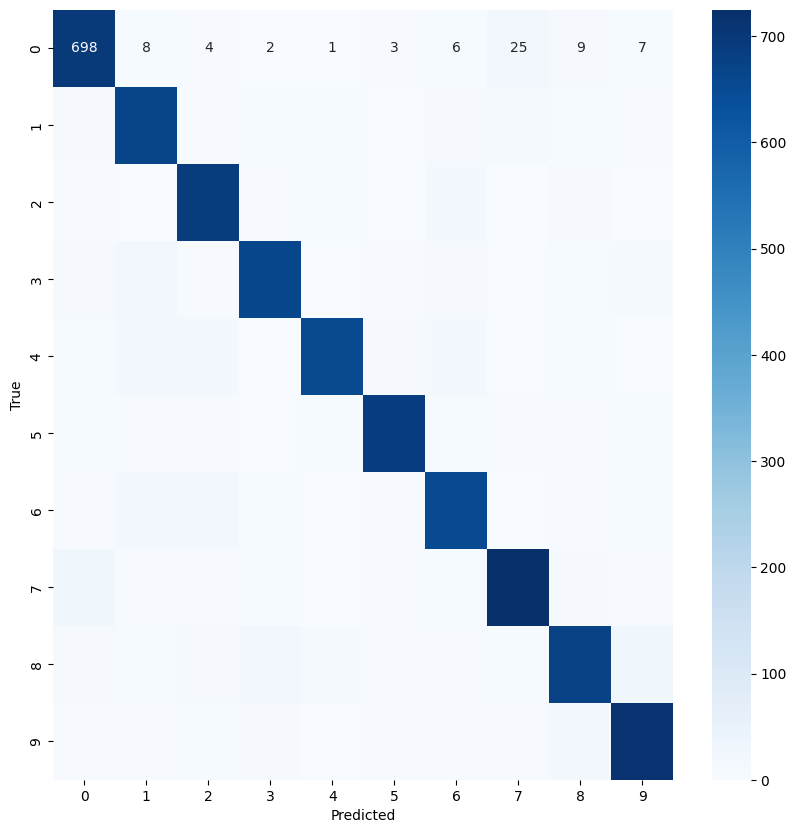

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_all_preds_and_labels(model, dataloader):
    # Empty tensors to store all predictions and true labels.
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    
    # Loop through the data in the dataloader.
    for inputs, labels in dataloader:
        # Convert inputs to float32
        inputs = inputs.float()
        # Move the data to the device (GPU/CPU).
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass to get predictions.
        outputs = model(inputs)
        
        # Get the index (class label) with the maximum score as the prediction.
        _, preds = torch.max(outputs, 1)
        
        # Append the batch's predictions and labels to the accumulating tensors.
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Return all predictions and true labels.
    return all_preds, all_labels

def plot_confusion_matrix(all_preds, all_labels):
    # Compute confusion matrix using sklearn's function.
    cm = confusion_matrix(all_labels.cpu(), all_preds.cpu())
    
    # Initialize a figure for plotting.
    plt.figure(figsize=(10, 10))
    
    # Use seaborn to plot a heatmap of the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    # x and y axis labels.
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Show the heatmap.
    plt.show()

cnn_model = cnn_model.float()
# Compute predictions and true labels for the CNN model on the test dataset.
all_preds, all_labels = get_all_preds_and_labels(cnn_model, DataLoader(test_dataset, batch_size=64))
plot_confusion_matrix(all_preds, all_labels)
